In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from qutip import *
from matplotlib import pyplot, animation
from mpl_toolkits.mplot3d import Axes3D

We will create magnetic field disturbance in a random orientation and with random magnitude. Later we will consider Hamiltonians, which depend on the magnetic field strength, and consider how the disturbance affects the dynamic and geometric phases.

We start by generating an arbitrary rotation and magnitude of the disturbance:

In [3]:
def dB(t,mu_r,sigma_r,mu_f,sigma_f,n):
    
    
    #Create random magnitudes sampled from a Gaussian:
    #We normalise so that the number of samplings does not increase the magnitude of the noise
    
    r = np.random.normal(mu_r, sigma_r, n)/n
    
    #Random frequency drawn from a gaussian:
    omega = np.random.normal(mu_f, sigma_f, n)
    
    
    #Random phase of the magnetic wave:
    phiB = np.random.uniform(0,np.pi*2,n)
    
    
    #Time dependent magnitude of the magnetic field vector
    
    
    x,y = np.meshgrid(omega,t)
    
    omega_t = x*y
        
    rt = r*np.sin(phiB + omega_t)
    
    
    #Random directions:
    phi = np.random.uniform(0,np.pi*2,n)
    costheta = np.random.uniform(-1,1,n)
        
    theta = np.arccos( costheta )
        
    #Time dependent projections:
    xf = np.sin( theta ) * np.cos( phi )*rt
    yf = np.sin( theta ) * np.sin( phi )*rt
    zf = np.cos( theta )*rt

    #Sum all the different frequency contributions:
    
    xt = np.sum(xf,axis=1)
    yt = np.sum(yf,axis=1)
    zt = np.sum(zf,axis=1)
    
    return xt,yt,zt

In [4]:
omega = np.arange(5,11,1)

t = np.arange(0,1.2,0.2)

x,y = np.meshgrid(t,omega)

In [5]:
t = np.arange(0,10,0.01)

B = dB(t,10,1,0,100,100)

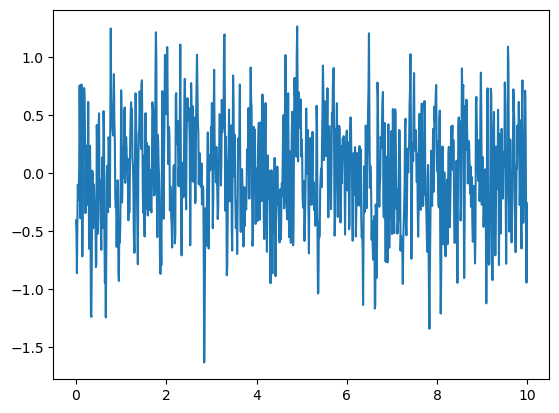

In [6]:
plt.figure()

plt.plot(t,B[0])

plt.show()

We will now create a function, which creates a Hamiltonian based on the magnetic field

In [7]:
def H(Bx,By,Bz):
    
    #Create Pauli matrices:
    
    sx = np.array([[0,1],[1,0]])
    sy = np.array([[0,-1.j],[1.j,0]])
    sz = np.array([[1,0],[0,-1]])
    
    #Create Hamiltonian:
    
    H = -(sx*Bx+sy*By+sz*Bz)
    
    return H
    

We create a dictionary to store all of the important data of for the state:

In [8]:
def psi_dict(psi_val,psi_time):
    #Create dictionary:
    
    
    psi_name = dict();
    
    #Insert the state into dictionary:
    
    psi_name['psi'] = psi_val
    
    #Allocate time steps
    psi_name['t'] = psi_time
    
    #Absolute values of entries:
    
    psi_name['abs'] = np.absolute(psi_val)
    
    #Populations:
    
    psi_name['pop'] = psi_name['abs']**2
    
    psi_name['pop_g'] =psi_name['pop'][:,0]
    
    psi_name['pop_e'] =psi_name['pop'][:,1]
    
    #Phases on entries:
    psi_name['angles'] = np.angle(psi_val)
    
    psi_name['angle_g']=psi_name['angles'][:,0]
    psi_name['angle_e']=psi_name['angles'][:,1]
    
    #Total phase:
    
    phase = []
    
    for i in range(len(psi_val)):
        phase.append(np.angle(np.vdot(psi_val[0],psi_val[i])))
    
    psi_name['theta'] = np.array(phase)
    
    #Geometric phase construction:
    
    #Azimuthal angle intervals:
    #New idea for implementation, where all angles are defined in complex exponentials to avoid problem with 2pi
    
    #Exponential of current phase difference between the two entries (without scaling)
    psi_name['exp_idphi_t'] = psi_val[:,1]*np.conj(psi_val[:,0])
    
    
    #Exponential time retarded by one step (without scaling)
    psi_name['exp_idphi_past'] = np.append(psi_name['exp_idphi_t'][0],psi_name['exp_idphi_t'])[:-1]
    
    
    #Difference in phase relation exponentiated (Scaling not important, since we take the argument)
    psi_name['exp_idphi'] = psi_name['exp_idphi_t']*np.conj(psi_name['exp_idphi_past'])
    
    #Difference in phase relation
    psi_name['dphi'] = np.angle(psi_name['exp_idphi'])
    
    #Change in geometric phase calculated from minus half the area change on the Bloch sphere 
    psi_name['dtheta_geo'] = -1*psi_name['pop_e']*psi_name['dphi']
    
    #Exponetiated geometric phase
    psi_name['exp_theta_geo'] = np.cumprod(np.exp(1.j*psi_name['dtheta_geo']))
    
    #Geometric phase
    psi_name['theta_geo'] = np.angle(psi_name['exp_theta_geo'])
    
    
    #Dynamic phase construction:
    
    psi_name['dpsi'] = np.append([psi_val[0]],psi_val,axis=0)[:-1]-psi_val
    
    dtheta_dyn = []
    
    for i in range(len(psi_val)):
        dtheta_dyn.append(np.imag(np.vdot(psi_val[i],psi_name['dpsi'][i])))
    
    psi_name['dtheta_dyn'] = np.array(dtheta_dyn)
    
    psi_name['theta_dyn'] = -np.cumsum(psi_name['dtheta_dyn'])
    
    
    #Qutip visualisation:
    
    #Change coords to their f****d convention, which deviates from QM!!!
    
    psi_name['z_coord'] = 2*psi_name['pop_g']-1
    
    #Here the first part is sin(theta) given the half angle nature of the Bloch Sphere
    
    psi_name['dphi_t'] = psi_name['angle_e']-psi_name['angle_g']
    
    psi_name['x_coord'] = 2*psi_name['abs'][:,0]*psi_name['abs'][:,1]*np.cos(psi_name['dphi_t'])
    
    psi_name['y_coord'] = 2*psi_name['abs'][:,0]*psi_name['abs'][:,1]*np.sin(psi_name['dphi_t'])
    
    psi_name['b_coord'] = np.array([psi_name['x_coord'],psi_name['y_coord'],psi_name['z_coord']]).T
    
    
    return psi_name

We are now ready to create a function, which takes a magnetic field and solves for the evolution of the quantum state for Lamour precession:

In [9]:
def Time_evolution_L(psi_0 = [1,0],mu_r=0.5,sigma_r=0.01,mu_f=10,sigma_f=5,n=5,T=3,step_nr=1000,dt_max=0.001):
    
    #Make psi_0 a complex array
    
    psi_0 = np.array(psi_0).astype('complex128')/np.sqrt(np.vdot(psi_0,psi_0))
    
    #Magnetic fields:
    
    def B(t):
        Bx = 1
        
        By = 0
        
        Bz = 0
        return Bx,By,Bz
    
    #Magnetic noise:
    
    def dB1(t):
        return dB(t,mu_r,sigma_r,mu_f,sigma_f,n)
    
    #Solve the SE equation:
    
    #Create time steps:
    
    steps = T*np.arange(step_nr)/step_nr
    
    #Solve without noise:
    
    def dpsi(t,psi):
        return -1.j*H(B(t)[0],B(t)[1],B(t)[2]).dot(psi)
    
    psi_solver =  solve_ivp(dpsi,[0,T],psi_0,max_step=dt_max,t_eval=steps)
    
    psi = psi_dict(psi_solver.y.T,psi_solver.t)
    
    #Solve with noise:
    
    def dpsi_n(t,psi):
        return -1.j*H(B(t)[0]+dB1(t)[0],B(t)[1]+dB1(t)[1],B(t)[2]+dB1(t)[2]).dot(psi)
    
    psi_n_solver =  solve_ivp(dpsi_n,[0,T],psi_0,max_step=dt_max,t_eval=steps)
    
    
    psi_n = psi_dict(psi_n_solver.y.T,psi_n_solver.t)
    
    return psi, psi_n

In [13]:
psi, psi_n = Time_evolution_L(psi_0=[2,1],T=20,mu_r=20,n=10,step_nr=100,dt_max=0.01)

In [10]:
plt.figure()

plt.plot(psi['t'],psi['pop'])


plt.show()

plt.figure()

plt.plot(psi_n['t'],psi_n['pop'])

plt.plot(psi_n['t'],psi_n['pop'][:,0]+psi_n['pop'][:,1])

plt.show()


NameError: name 'psi' is not defined

<Figure size 640x480 with 0 Axes>

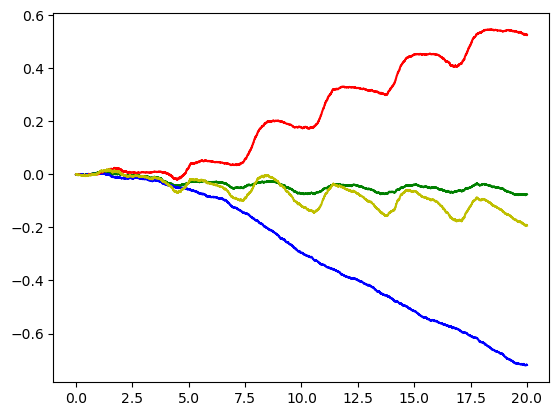

In [66]:
plt.figure()

plt.plot(psi['t'],(np.angle(np.exp(1.j*(psi['theta']-psi_n['theta']))))/np.pi,color='g')

plt.plot(psi['t'],(np.angle(np.exp(1.j*(psi['theta_dyn']-psi_n['theta_dyn']))))/np.pi,color='b')

plt.plot(psi['t'],(np.angle(np.exp(1.j*(psi['theta_geo']-psi_n['theta_geo']))))/np.pi,color='r')

plt.plot(psi['t'],(np.angle(np.exp(1.j*(psi['theta_dyn']-psi_n['theta_dyn']+psi['theta_geo']-psi_n['theta_geo']))))/np.pi,color='y')


plt.show()

We will now solve for Adiabatic evolution

In [11]:
def Time_evolution_A(psi_0 = [1,0,0],mu_r=0.5,sigma_r=0.01,mu_f=10,sigma_f=5,n=5,T=3,dt_max=0.0001,step_nr=1000,omega_B = 0.1*np.pi,B_amp=10):
    
    #Make psi_0 a complex array
    
    psi_0 = np.array(psi_0).astype('complex128')/np.sqrt(np.vdot(psi_0,psi_0))
    
    #Magnetic fields:
    
    def B(t):
        Bx = B_amp*np.sin(omega_B*t)
        
        By = B_amp*0
        
        Bz = B_amp*np.cos(omega_B*t)
        
        return Bx,By,Bz
    
    #Magnetic noise:
    
    def dB1(t):
        return dB(t,mu_r,sigma_r,mu_f,sigma_f,n)
    
    #Solve the SE equation:
    
    #Create time steps:
    
    steps = T*np.arange(step_nr)/step_nr
    
    #Solve without noise:
    
    def dpsi(t,psi_theta):
        psi = psi_theta[0:2]
        Hamilton = H(B(t)[0],B(t)[1],B(t)[2])
        return np.append(-1.j*Hamilton.dot(psi),[-np.vdot(psi,Hamilton.dot(psi))])
    
    psi_solver =  solve_ivp(dpsi,[0,T],psi_0,max_step=dt_max,t_eval=steps)
    
    
    psi = psi_dict(psi_solver.y[0:2].T,psi_solver.t)
    
    #Solve with noise:

    def dpsi_n(t,psi_theta):
        psi = psi_theta[0:2]
        Hamilton = H(B(t)[0]+dB1(t)[0],B(t)[1]+dB1(t)[1],B(t)[2]+dB1(t)[2])
        return np.append(-1.j*Hamilton.dot(psi),[-np.vdot(psi,Hamilton.dot(psi))])
        
    psi_n_solver =  solve_ivp(dpsi_n,[0,T],psi_0,max_step=dt_max,t_eval=steps)
    
    
    psi_n = psi_dict(psi_n_solver.y[0:2].T,psi_n_solver.t)
    
    return psi, psi_n, np.real(psi_solver.y[2].T), np.real(psi_n_solver.y[2].T)

In [66]:
psi_A,psi_A_n, theta_dyn, theta_n_dyn = Time_evolution_A(psi_0=[1,0.01,0],T=80,B_amp=10,omega_B=0.1,n=5,mu_r=5,mu_f=200,sigma_f=50,dt_max=0.001,step_nr=10000)

psi_A1,psi_A1_n, theta_dyn, theta_n_dyn = Time_evolution_A(psi_0=[1,0,0],T=80,B_amp=10,omega_B=0.1,n=5,mu_r=5,mu_f=200,sigma_f=50,dt_max=0.001,step_nr=10000)

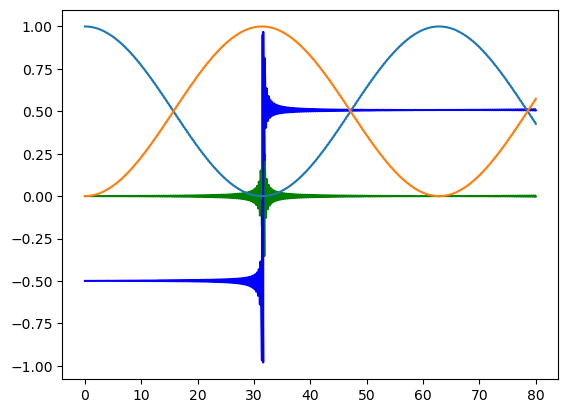

In [70]:
plt.figure()

#plt.plot(psi_A['t'],np.angle(np.exp(1.j*(theta_n_dyn-theta_dyn))),color='b')

theta_geo = psi_A['theta']-theta_dyn

theta_n_geo = psi_A_n['theta']-theta_n_dyn


#plt.plot(psi_A['t'][22000:40000],np.angle(np.exp(1.j*(theta_geo[22000:40000]))),color='r')

#plt.plot(psi_A['t'],psi_A['pop'])

#plt.plot(psi_A['t'],np.angle(np.exp(1.j*(theta_n_geo-theta_geo))),color='r')

#plt.plot(psi_A['t'],np.angle(np.exp(1.j*(psi_A_n['theta']-psi_A['theta']))),color='g')


plt.plot(psi_A['t'],np.angle(np.exp(1.j*(psi_A['theta']-psi_A1['theta'])))/(np.pi),color='g')

plt.plot(psi_A['t'],np.angle(np.exp(1.j*(theta_geo-np.pi/2)))/(np.pi),color='b')

plt.plot(psi_A['t'],psi_A1['pop'])


plt.show()

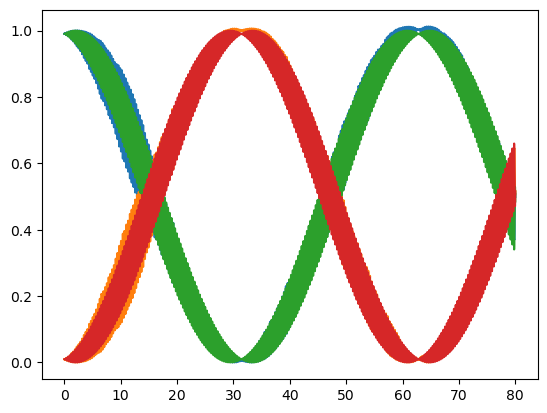

In [37]:
plt.figure()

plt.plot(psi_A['t'],psi_A_n['pop'])

plt.plot(psi_A['t'],psi_A['pop'])

plt.show()

In [25]:
psi_A,psi_A_n, theta_dyn, theta_n_dyn = Time_evolution_A(T=15,B_amp=10,omega_B=0.1,n=5,mu_r=5,mu_f=200,sigma_f=50,step_nr=100,dt_max=0.001)

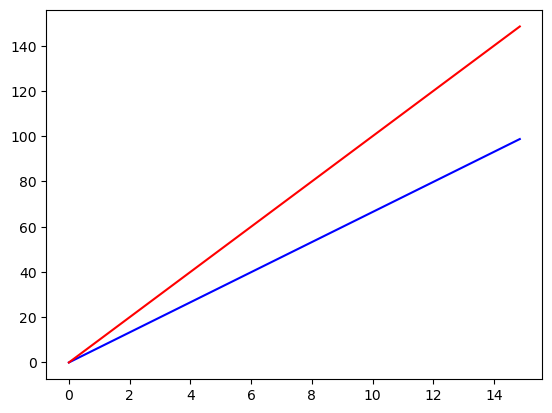

In [27]:
plt.figure()

plt.plot(psi_A['t'],psi_A['theta_dyn'],color='b')

plt.plot(psi_A['t'],theta_dyn,color='r')

plt.show()

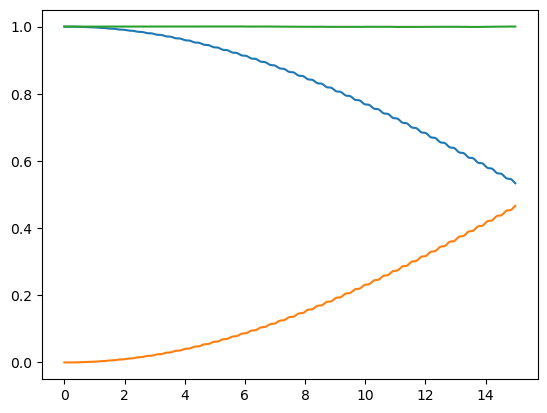

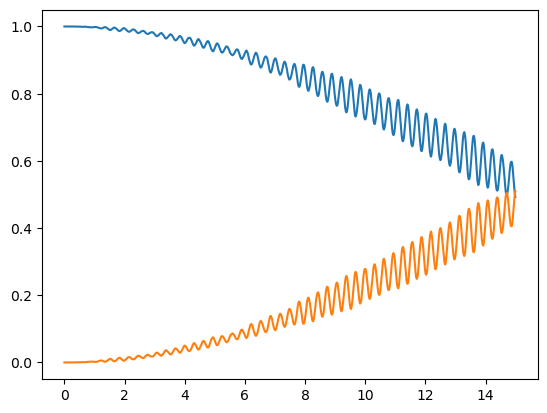

In [21]:
plt.figure()

plt.plot(psi_A['t'],psi_A['pop'])

#plt.plot(psi_A['t'],psi_A['pop'][:,0]+psi_A['pop'][:,1])

Fidelity = []

for i in range(len(psi_A['t'])):
    Fidelity.append(np.absolute(np.vdot(psi_A['psi'][i],psi_A_n['psi'][i])))

Fidelity = np.array(Fidelity)

plt.plot(psi_A['t'],Fidelity)

plt.show()

plt.figure()

plt.plot(psi_A_n['t'],psi_A_n['pop'])

plt.show()

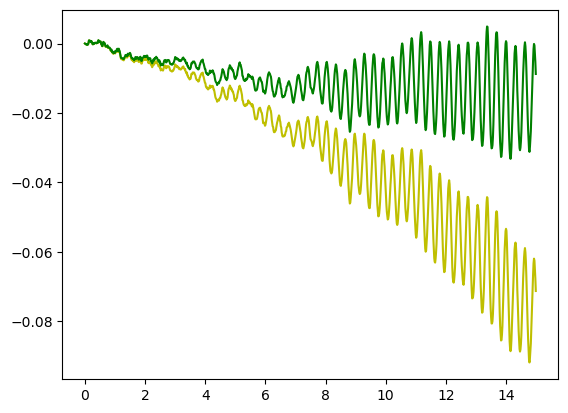

In [22]:
plt.figure()




#plt.plot(psi_A['t'],(np.angle(np.exp(1.j*(psi_A['theta_geo']+psi_A['theta_dyn']-psi_A_n['theta_dyn']-psi_A_n['theta_geo']))))/np.pi,color='r')


#plt.plot(psi_A['t'],psi_A['pop'])


#plt.plot(psi_A['t'],(np.angle(np.exp(1.j*(psi_A['theta_geo']-psi_A_n['theta_geo']))))/np.pi,color='r')


#plt.plot(psi_A['t'],(np.angle(np.exp(1.j*(psi_A['theta_dyn']-psi_A_n['theta_dyn']))))/np.pi,color='b')


plt.plot(psi_A['t'],(np.angle(np.exp(1.j*(psi_A['theta_geo']+psi_A['theta_dyn']-psi_A_n['theta_geo']-psi_A_n['theta_dyn']))))/np.pi,color='y')


plt.plot(psi_A['t'],(np.angle(np.exp(1.j*(psi_A['theta']-psi_A_n['theta']))))/np.pi,color='g')


plt.show()

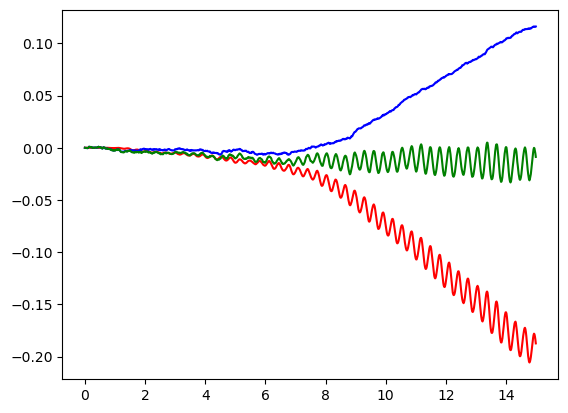

In [23]:
plt.figure()




#plt.plot(psi_A['t'],(np.angle(np.exp(1.j*(psi_A['theta_geo']+psi_A['theta_dyn']-psi_A_n['theta_dyn']-psi_A_n['theta_geo']))))/np.pi,color='r')


#plt.plot(psi_A['t'],psi_A['pop'])


plt.plot(psi_A['t'],(np.angle(np.exp(1.j*(psi_A['theta_geo']-psi_A_n['theta_geo']))))/np.pi,color='r')


plt.plot(psi_A['t'],(np.angle(np.exp(1.j*(psi_A['theta_dyn']-psi_A_n['theta_dyn']))))/np.pi,color='b')

plt.plot(psi_A['t'],(np.angle(np.exp(1.j*(psi_A['theta']-psi_A_n['theta']))))/np.pi,color='g')


#plt.plot(psi_A['t'],(np.angle(np.exp(1.j*(psi_A['theta_geo']+psi_A['theta_dyn']))))/np.pi,color='r')


#plt.plot(psi_A['t'],(np.angle(np.exp(1.j*(psi_A['theta']))))/np.pi,color='g')


#plt.plot(psi_A['t'],(np.angle(np.exp(1.j*(psi_A_n['theta_geo']+psi_A_n['theta_dyn']))))/np.pi,color='r')


#plt.plot(psi_A['t'],(np.angle(np.exp(1.j*(psi_A_n['theta']))))/np.pi,color='g')



plt.show()


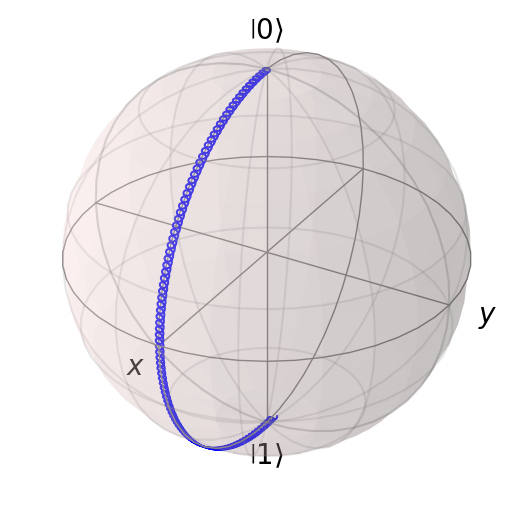

In [72]:
b = qutip.Bloch()

b.make_sphere()

e = 4000

x = psi_A['x_coord'][:e]

y = psi_A['y_coord'][:e]

z = psi_A['z_coord'][:e]



x_n = psi_A_n['x_coord'][:e]

y_n = psi_A_n['y_coord'][:e]

z_n = psi_A_n['z_coord'][:e]

#b.add_points([x_n,y_n,z_n], meth='l')

b.add_points([x,y,z], meth='l')

b.render()
b.show()